In [1]:
# import 
import numpy as np
from scipy.stats import chi2
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import polars as pl
import pandas as pd
import seaborn as sns
import torch
import lightning as L
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix, roc_curve
from omegaconf import OmegaConf, DictConfig
import hydra
import wandb
from dataset import SupervisedDataset
from lightning_modules import SupervisedTask
from models.ecg_models import *
from run import interpolate
pl.Config.set_tbl_rows(50)
MY_NAVY = '#001F54'

/home/chandak/miniconda3/envs/ecg/lib/python3.8/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
import os 
import numpy as np
import polars as pl 
import ipdb
dir = '/storage2/payal/dropbox/private/data/'
writefile = '/storage2/payal/dropbox/private/SILVER/data/data.parquet'

seed = 140799
np.random.seed(seed)
pl.set_random_seed(seed)
mrn = pl.read_parquet(os.path.join(dir, 'processed', 'mrn.parquet'))
external_cohort = mrn.filter(pl.col('mgh_mrn').is_null()).select('empi').to_numpy().reshape(-1)

split = pl.concat([
    mrn.filter(
        ~pl.col('empi').is_in(external_cohort)
    ).with_columns(
        pl.Series(
        name='split',
        values=np.random.choice(
            a=['train','tune','test'],
            size=mrn.height-len(external_cohort)-1,
            replace=True,
            p=[.75,.10,.15]
        ))
    ),
    mrn.filter(
        pl.col('empi').is_in(external_cohort)
    ).with_columns(
        pl.lit('external').alias('split')
    ), 
])

def separate_cohorts(df, external_cohort): 
    return df.filter(
        ((pl.col('empi').is_in(external_cohort)) & (pl.col('hospital')=='BWH'))
        | 
        ((~pl.col('empi').is_in(external_cohort)) & (pl.col('hospital')=='MGH'))
    ).drop(
        'hospital'
    )

def diagnosis_date(name): 
    df = pl.read_parquet(os.path.join(dir, 'processed', 'diagnosis.parquet'))

    disease_names = df.select(['name']
    ).unique().filter(
        pl.col('name').str.to_lowercase().str.contains(name)
    ).to_numpy().reshape(-1)

    return df.filter(
        pl.col('name').is_in(disease_names)
    ).select(
        ['empi', 'date']
    ).sort(
        ['empi', 'date',]
    ).unique(
        subset='empi',
        keep='first'
    ).rename(
        {'date':'diagnosis_date'}
    )

def add_comorbidity(df, name): 
    return df.join(
        diagnosis_date(name), 
        on='empi',
        how='left',
    ).with_columns(
        pl.when(
            pl.col('diagnosis_date') <= pl.col('ecg_date')
        ).then(
            1
        ).otherwise(
            0
        ).alias(
            name.replace(' ','_')
        )
    ).drop(
        'diagnosis_date'
    )

def after_hf_diagnosis(df, date_col): 
    return df.join(
        diagnosis_date('heart failure'),
        on='empi',
    ).filter(
        pl.col('diagnosis_date')<=pl.col(date_col)
    ).with_columns(
        (pl.col(date_col)-pl.col('diagnosis_date')).dt.total_days().alias('days_since_diagnosis')
    ).drop(
        'diagnosis_date'
    )

ecg = pl.read_parquet(
    os.path.join(dir, 'processed', 'ecg.parquet')
).pipe(
    separate_cohorts, external_cohort
).rename(
    {'date':'ecg_date', 'path':'ecg_path'}
).with_columns( # drop ECGs within 1 hour of each other 
    pl.col('ecg_date').dt.round(every='1h').alias('ecg_date_round')
).filter(
    pl.col('ecg_date')<=pl.date(year=2025,month=1,day=1)
).sort(
    ['empi','ecg_date']
).unique(
    subset=['empi','ecg_date_round'],
    keep='last',
).drop(
    'ecg_date_round'
).pipe(
    after_hf_diagnosis,
    date_col='ecg_date',
).pipe(
    add_comorbidity, name='diabetes mellitus'
).pipe(
    add_comorbidity, name='hypertension'
).pipe(
    add_comorbidity, name='atheroscler'
).pipe(
    add_comorbidity, name='chronic obstructive pulmonary disease'
).pipe(
    add_comorbidity, name='atrial fibrillation'
).unique(
    ['empi','ecg_date']
)

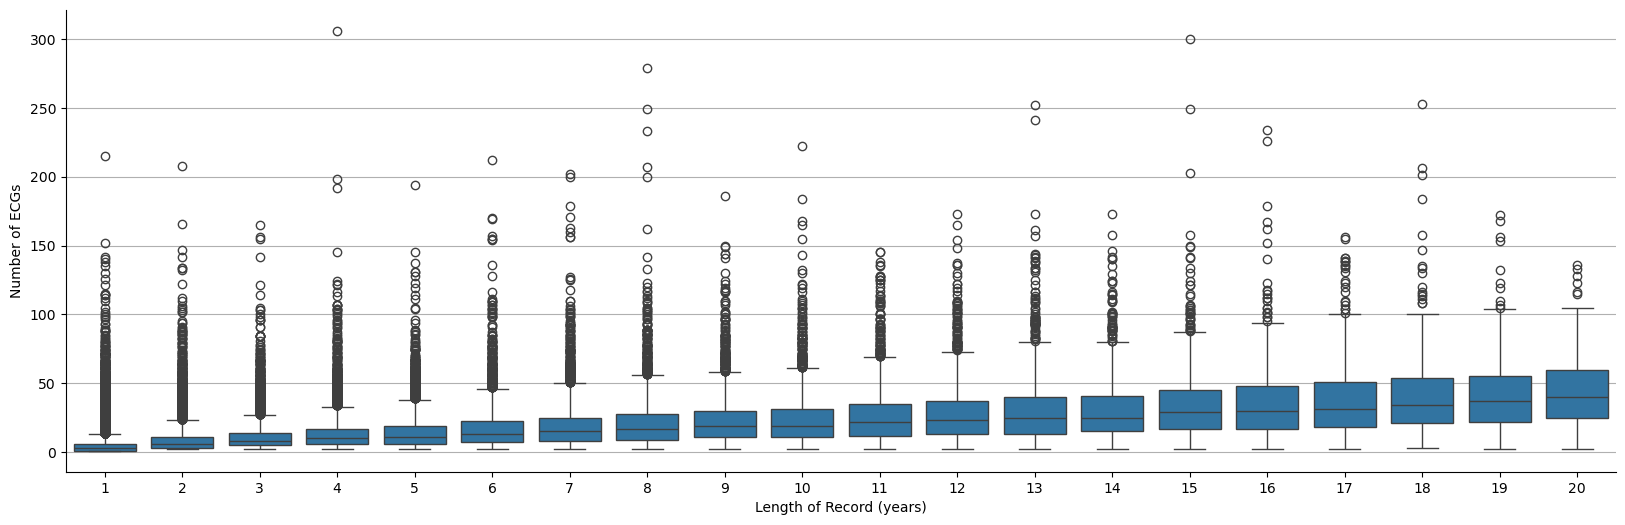

In [4]:
# ecg distribution
data = []
for pt, group in ecg.select(['empi','ecg_date']).unique().group_by('empi'): 
    years_w_ecgs = group.with_columns(pl.col('ecg_date').dt.year())['ecg_date'].to_list()
    years_in_record = max(years_w_ecgs) - min(years_w_ecgs) + 1
    data.append((len(years_w_ecgs), years_in_record))
data = pd.DataFrame(data, columns=["ECGs", "Years"])
data = data.query("Years<=20")
plt.figure(figsize=(20, 6))
sns.boxplot(data, x="Years", y="ECGs")
sns.despine()
plt.grid(axis='y')
plt.xlabel("Length of Record (years)")
plt.ylabel("Number of ECGs")
plt.show()

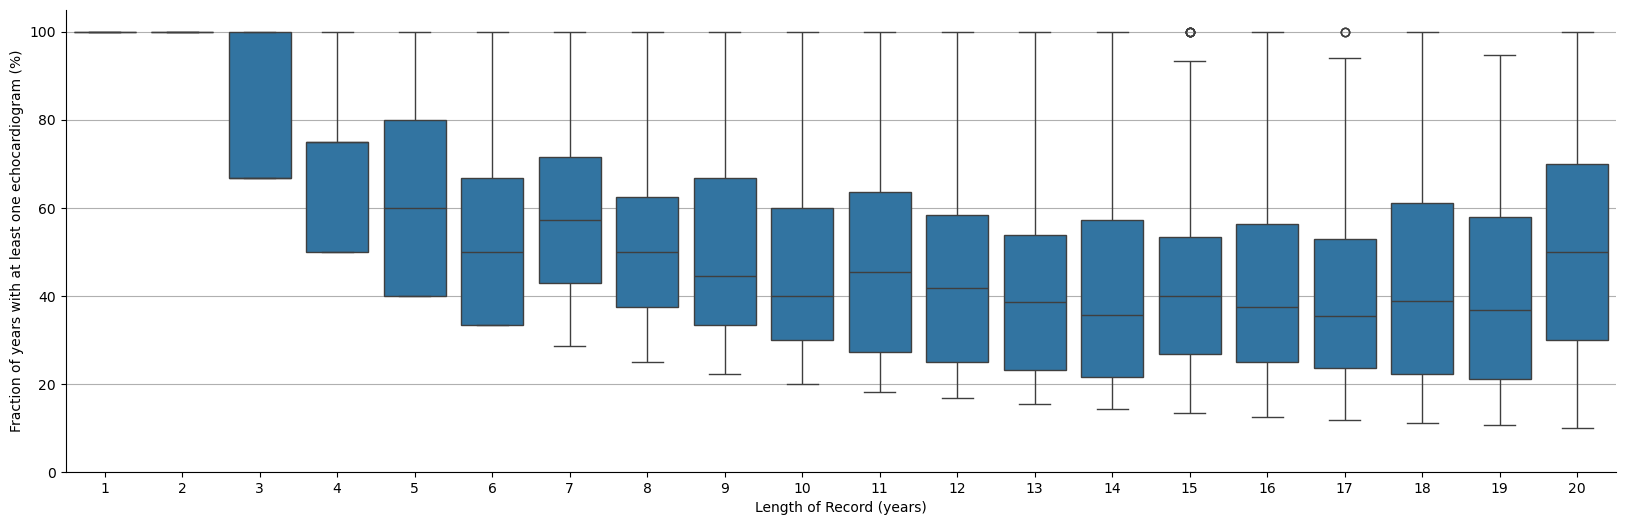

In [87]:
# echo distribution 
lvef = pl.read_parquet(
    os.path.join(dir, 'processed', 'lvef.parquet')
).pipe(
    separate_cohorts, external_cohort
).pipe(
    after_hf_diagnosis,
    date_col='lvef_date',
).drop(
    'days_since_diagnosis'
)
data = []
for pt, group in lvef.with_columns(pl.col('lvef_date').dt.year()
                ).select(['empi','lvef_date']).unique().group_by('empi'): 
    years_w_lvef = group['lvef_date'].to_list()
    years_in_record = max(years_w_lvef) - min(years_w_lvef) + 1
    percent_w_lvef = 100*len(years_w_lvef)/years_in_record
    data.append((percent_w_lvef, years_in_record))
data = pd.DataFrame(data, columns=["percent", "years"])
data = data.query('years<=20')
plt.figure(figsize=(20, 6))
sns.boxplot(data, x="years", y="percent")
sns.despine()
plt.ylim(0,105)
plt.grid(axis='y')
plt.xlabel("Length of Record (years)")
plt.ylabel("Fraction of years with at least one echocardiogram (%)")
plt.show()

In [93]:
data.describe()

,percent,years
count,88288.000000,88288.000000
mean,87.448167,3.036245
std,23.052231,3.682200
min,10.000000,1.000000
25%,80.000000,1.000000
50%,100.000000,1.000000
75%,100.000000,4.000000
max,100.000000,20.000000


In [67]:
switch = {
    'MGH':[],
    'BWH':[],
}
for pt, group in lvef.group_by('empi'): 
    if group.filter(pl.col('hospital')=='BWH').height > 0: 
        hosp = 'BWH'
    else: 
        hosp = 'MGH'
    s = group.sort(
        ["empi", "lvef_date"]
    ).with_columns(
        (pl.col("lvef") > 40).cum_sum().alias("keep_flag") 
    ).filter(
        pl.col("keep_flag") > 0
    ).drop(
        "keep_flag"
    ).filter(
        pl.col('lvef')<=40
    ).height > 0 
    switch[hosp].append(s)

In [55]:
100*sum(switch['MGH'])/len(switch['MGH']), len(switch['MGH'])

(9.421518478073452, 139192)

In [68]:
100*sum(switch['BWH'])/len(switch['BWH']), len(switch['BWH'])

(10.288047379755923, 66864)

In [69]:
df = pl.read_parquet('/storage2/payal/Dropbox (Partners HealthCare)/private/SILVER/data/data.parquet')

In [107]:
import os 
import numpy as np 
import polars as pl 
import ipdb
dir = '/storage/shared/mimic/'
writefile = '/storage/shared/mimic/data.parquet'

seed = 140799
np.random.seed(seed)
pl.set_random_seed(seed)
mrn = pl.read_csv(os.path.join(dir, 'raw/hosp', 'patients.csv'))
mrn = mrn.select(['subject_id','gender']).rename({'subject_id':'empi','gender':'sex'})

split = mrn.with_columns(pl.lit('mimic').alias('split'))

def diagnosis_date(name): 
    df = pl.read_csv(
        os.path.join(dir, 'raw/hosp', 'diagnoses_icd.csv')
    ).join(
        pl.read_csv(os.path.join(dir, 'raw/hosp', 'admissions.csv')),
        on=['subject_id','hadm_id']
    ).join(
        pl.read_csv(os.path.join(dir, 'raw/hosp', 'd_icd_diagnoses.csv'), infer_schema_length=100000),
        on=['icd_code', 'icd_version']
    ).select(
        ['subject_id','long_title','admittime']
    ).unique(
        
    ).with_columns(
        pl.col("admittime").str.strptime(pl.Datetime, "%Y-%m-%d %H:%M:%S").dt.date().alias("admittime")
    ).rename({
        'subject_id':'empi',
        'long_title':'name',
        'admittime':'date',
    })

    disease_names = df.select(['name']
    ).unique().filter(
        pl.col('name').str.to_lowercase().str.contains(name)
    ).to_numpy().reshape(-1)

    return df.filter(
        pl.col('name').is_in(disease_names)
    ).select(
        ['empi', 'date']
    ).sort(
        ['empi', 'date',]
    ).unique(
        subset='empi',
        keep='first'
    ).rename(
        {'date':'diagnosis_date'}
    )

def add_comorbidity(df, name): 
    return df.join(
        diagnosis_date(name), 
        on='empi',
        how='left',
    ).with_columns(
        pl.when(
            pl.col('diagnosis_date') <= pl.col('ecg_date')
        ).then(
            1
        ).otherwise(
            0
        ).alias(
            name.replace(' ','_')
        )
    ).drop(
        'diagnosis_date'
    )

def after_hf_diagnosis(df, date_col): 
    return df.join(
        diagnosis_date('heart failure'),
        on='empi',
    ).filter(
        pl.col('diagnosis_date')<=pl.col(date_col)
    ).with_columns(
        (pl.col(date_col)-pl.col('diagnosis_date')).dt.total_days().alias('days_since_diagnosis')
    ).drop(
        'diagnosis_date'
    )

ecg = pl.read_csv(
    os.path.join(dir, 'raw/ecg', 'good_record_list.csv')
).rename(
    {'subject_id':'empi', 'ecg_time':'ecg_date', 'path':'ecg_path'}
).select(
    ['empi','ecg_date','ecg_path']
).with_columns(
    pl.col("ecg_date").str.strptime(pl.Datetime, "%Y-%m-%d %H:%M:%S")
).with_columns( # drop ECGs within 1 hour of each other 
    pl.col('ecg_date').dt.round(every='1h').alias('ecg_date_round')
).sort(
    ['empi','ecg_date']
).unique(
    subset=['empi','ecg_date_round'],
    keep='last',
).drop(
    'ecg_date_round'
).pipe(
    after_hf_diagnosis,
    date_col='ecg_date',
).unique(
    ['empi','ecg_date']
)


lvef = pl.read_csv(
    os.path.join(dir, 'raw', 'lvef.csv')
).rename({
    'subject_id':'empi',
    'study_datetime':'lvef_date',
    'result':'lvef'
}).drop(
    'measurement'
).filter(
    pl.col('lvef').is_not_null()
).with_columns(
    pl.col('lvef').cast(pl.Int64),
    pl.col("lvef_date").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S").dt.date()
).filter(
    (pl.col('lvef')>0) & (pl.col('lvef')<100)
).pipe(
    after_hf_diagnosis,
    date_col='lvef_date',
).drop(
    'days_since_diagnosis'
)


In [108]:
switch = {
    'MIMIC':[],
}
for pt, group in lvef.group_by('empi'): 
    hosp='MIMIC'
    s = group.sort(
        ["empi", "lvef_date"]
    ).with_columns(
        (pl.col("lvef") > 40).cum_sum().alias("keep_flag") 
    ).filter(
        pl.col("keep_flag") > 0
    ).drop(
        "keep_flag"
    ).filter(
        pl.col('lvef')<=40
    ).height > 0 
    switch[hosp].append(s)

In [109]:
100*sum(switch['MIMIC'])/len(switch['MIMIC']), len(switch['MIMIC'])

(6.757580374828584, 13126)